# A 1D example with Normal modes

In this example we will solve the classic error free SOLA problem in 1D when data depends on multiple physical parameters:
$$
\begin{gather}
    \nonumber \text{Given the data constraint} \\ 
    d_i = G(m) = \int_0^R K^0_i(r) \delta v_p(r) dr + \int_0^R K^1_i(r) \delta v_s(r) dr \\
    \nonumber \text{We want to find} \\
    p_i = T(m) = \int_0^R T^0_i(r) \delta v_p(r) dr + \int_0^R T^1_i(r) \delta v_s(r) dr
\end{gather}
$$

First we import the needed modules

In [1]:
import sys
import os
current_location = os.getcwd()
sys.path.append(os.path.join(current_location, 'core'))
from core.main_classes.spaces import RN, PCb
from core.main_classes.domains import HyperParalelipiped
from core.main_classes.mappings import *

# This contains various functions for loading and handling normal mode data 
from core.aux.normal_data import * 

Then we import the kernel data - both vp and vs 

In [2]:
# Directory where all the data is and whether we want vs or vp etc
data_directory = 'kernels_modeplotaat_Adrian'
kernel_type_1 = 'vs'
kernel_type_2 = 'vp'
# Read the file that contains all available modes 
vs_kernel_discrete_domain, vs_discrete_sensitivity_kernels = load_normal_data(kernel_type_1, data_directory)
vp_kernel_discrete_domain, vp_discrete_sensitivity_kernels = load_normal_data(kernel_type_2, data_directory)

This data is, however, discrete. We need the sensitivity kernels to be functions defined on a continuous domain. We create interpolation functions based on the discrete sensitivity kernels using the Interpolation_1D class in functions.py. (Important discussion: what errors are introduced by the discreteness of the sensitivity kernels and the choice of interpolation for it?)

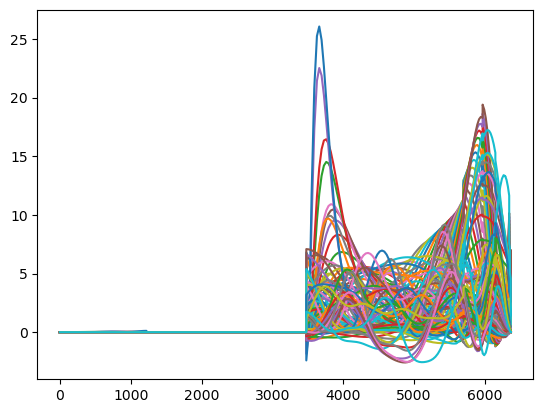

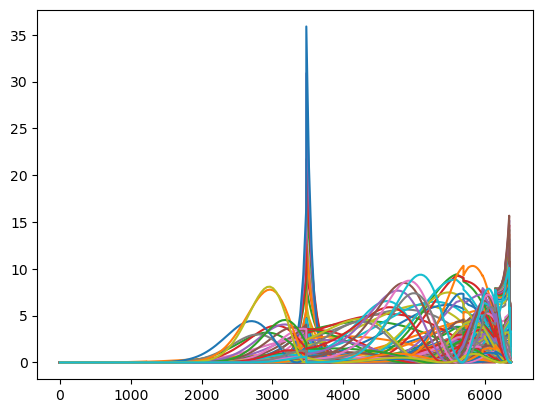

In [3]:
%matplotlib inline
# Create Earth 1D domain
EarthDomain = HyperParalelipiped(bounds=[[vs_kernel_discrete_domain[0], 
                                          vs_kernel_discrete_domain[-1]]], 
                                          fineness=1000)

plt.figure(101)
vs_sensitivity_kernels = []
how_many_kernels_to_load = 100#len(discrete_sensitivity_kernels)
for i, discrete_sensitivity_kernel in enumerate(vs_discrete_sensitivity_kernels[0:how_many_kernels_to_load]):
    vs_sensitivity_kernels.append(Interpolation_1D(values=discrete_sensitivity_kernel,
                                                raw_domain=vs_kernel_discrete_domain,
                                                domain=EarthDomain))
    plt.plot(vs_kernel_discrete_domain, discrete_sensitivity_kernel)
plt.show()

plt.figure(102)
vp_sensitivity_kernels = []
how_many_kernels_to_load = 100#len(discrete_sensitivity_kernels)
for i, discrete_sensitivity_kernel in enumerate(vp_discrete_sensitivity_kernels[0:how_many_kernels_to_load]):
    vp_sensitivity_kernels.append(Interpolation_1D(values=discrete_sensitivity_kernel,
                                                raw_domain=vp_kernel_discrete_domain,
                                                domain=EarthDomain))
    plt.plot(vp_kernel_discrete_domain, discrete_sensitivity_kernel)
plt.show()

Then we create the needed spaces. We first create the model spaces for $v_s$ and $v_p$ individually, then we form the full model space by taking the direct sum of them. 

In [4]:
# Create constituent model spaces
M_vs = PCb(domain=EarthDomain)
M_vp = PCb(domain=EarthDomain)
# Create the model space
M = DirectSumSpace((M_vs, M_vp))
# Create Data space (must know number of sensitivity kernels)
D = RN(dimension=how_many_kernels_to_load)
# Create Property space (must know number of target kernels)
no_targets = 100  # Number of targets we will use
P = RN(dimension=no_targets)

And the mappings. For the property mapping we also need to create some target kernels. We now need target kernels for both physical parameters. Similarly, we create a direct sum mapping.

In [5]:
# Create vs and vp Data mapping (must have the sensitivity kernels)
G_vs = IntegralMapping(domain=M_vs, codomain=D, kernels=vs_sensitivity_kernels)
G_vp = IntegralMapping(domain=M_vp, codomain=D, kernels=vp_sensitivity_kernels)
# Now create the direct sum of these two mappings
G = DirectSumMapping(domain=M, codomain=D, mappings=(G_vs, G_vp))
# Create Target kernels
width = 1000 # same units as domain (km here)
enquiry_points = np.linspace(EarthDomain.bounds[0][0], 
                             EarthDomain.bounds[0][1], 
                             no_targets) # these are the locations where we center our targets

vs_target_kernels = []
vp_target_kernels = []
for i in range(no_targets):
    vs_target_kernels.append(Gaussian_1D(domain=EarthDomain,
                               center=enquiry_points[i],
                               width=width))
    vp_target_kernels.append(Null_1D(domain=EarthDomain))
# You can also try to replace Gaussian_1D with Boxcar_1D or DGaussian_1D
T_vs = IntegralMapping(domain=M_vs, codomain=P, kernels=vs_target_kernels)
T_vp = IntegralMapping(domain=M_vp, codomain=P, kernels=vp_target_kernels)
# Now create the direct sum of these two mappings
T = DirectSumMapping(domain=M, codomain=P, mappings=(T_vs, T_vp))

Now we generate some fake true model and data (both for $v_s$ and $v_p$)

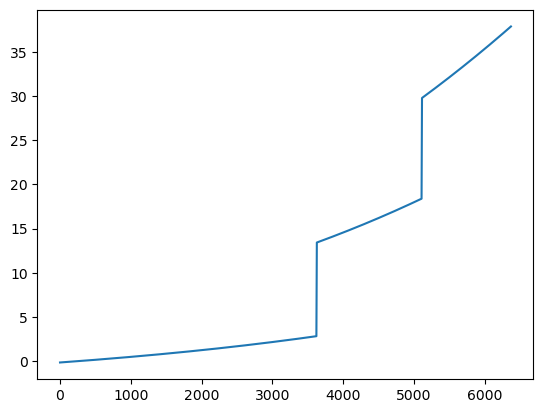

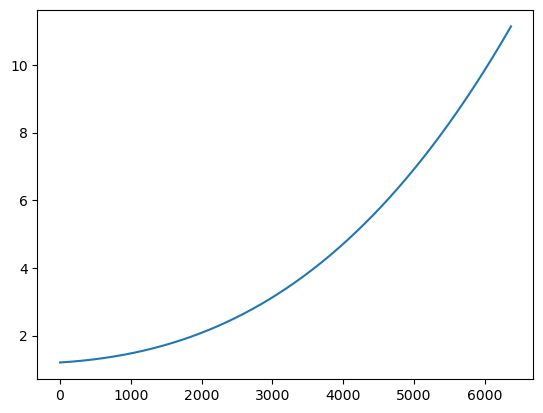

In [6]:
true_model = M.random_member(args_list=[(1,), (2,)]) # the arguments are the seeds for generating the random models
true_model[0].plot() # vs
true_model[1].plot() # vp

data = G.map(true_model)

Now we obtain the least norm solution. This is done jointly. 

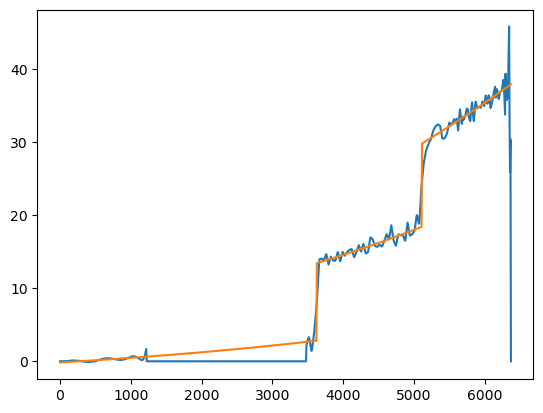

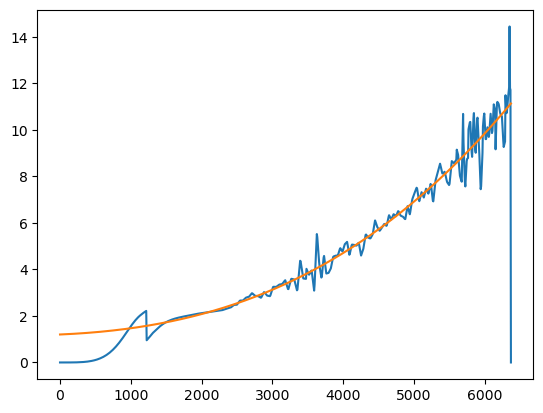

In [7]:
# Find adjoint of data mapping
G_adjoint = G.adjoint()
# Find the Lambda matrix
Lambda = G._compute_GramMatrix()
# Now we invert Lambda
Lambda_inv = Lambda.invert()
# And finally find the least norm solution
least_norm_solution = G_adjoint.map(Lambda_inv.map(data))
# And we plot it
plt.plot(EarthDomain.mesh, 
         least_norm_solution[0].evaluate(EarthDomain.mesh)[1])
plt.plot(EarthDomain.mesh, true_model[0].evaluate(EarthDomain.mesh)[1])
plt.show()
plt.plot(EarthDomain.mesh, 
         least_norm_solution[1].evaluate(EarthDomain.mesh)[1])
plt.plot(EarthDomain.mesh, true_model[1].evaluate(EarthDomain.mesh)[1])
plt.show()

Now we want to compute the Resolving kernels. For this we need the X matrix: 

In [8]:
Gamma = T*G_adjoint
X = Gamma * Lambda_inv
resolving_kernels_vs = np.dot(X.matrix, vs_sensitivity_kernels)
resolving_kernels_vp = np.dot(X.matrix, vp_sensitivity_kernels)


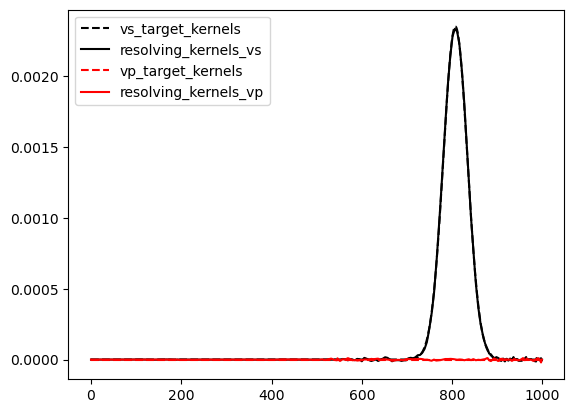

In [9]:
# Choose which resolving kernel to plot below
which = 80
plt.figure(1)

# Plotting with legends
plt.plot(vs_target_kernels[which].evaluate(EarthDomain.mesh)[1], color='black', linestyle='dashed', label='vs_target_kernels')
plt.plot(resolving_kernels_vs[which].evaluate(EarthDomain.mesh)[1], color='black', linestyle='solid', label='resolving_kernels_vs')
plt.plot(vp_target_kernels[which].evaluate(EarthDomain.mesh)[1], color='red', linestyle='dashed', label='vp_target_kernels')
plt.plot(resolving_kernels_vp[which].evaluate(EarthDomain.mesh)[1], color='red', linestyle='solid', label='resolving_kernels_vp')

# Add legend
plt.legend()
plt.show()

And we compute the least norm solution property

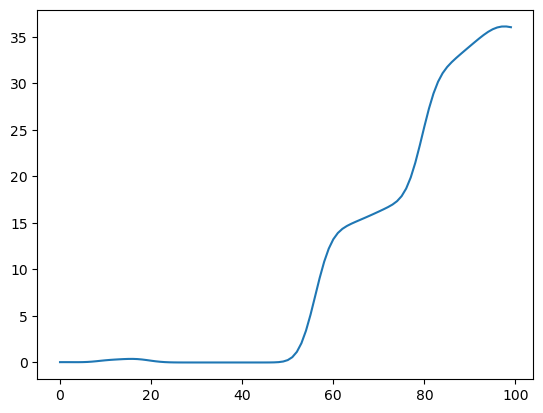

In [10]:
least_norm_property = X.map(data)
plt.plot(least_norm_property)

To compute the bounds we will need the diagonal of $\mathcal{H} = \chi - \Gamma \Lambda^{-1} \Gamma^*$ matrix, which are simply $\int (T^0_i - A^0_i)^2 + \int (T^1_i - A^1_i)^2$ and a norm Bound $M$. Let's start by computing a norm bound using piecewise functions.

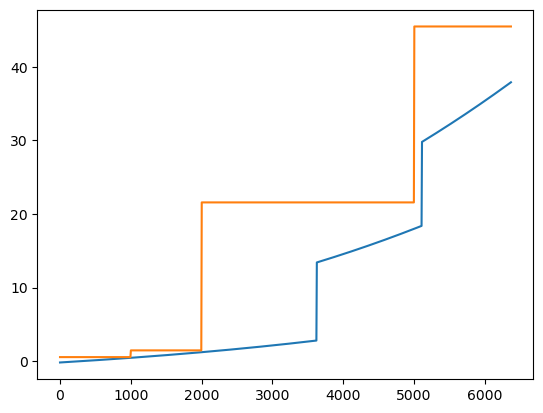

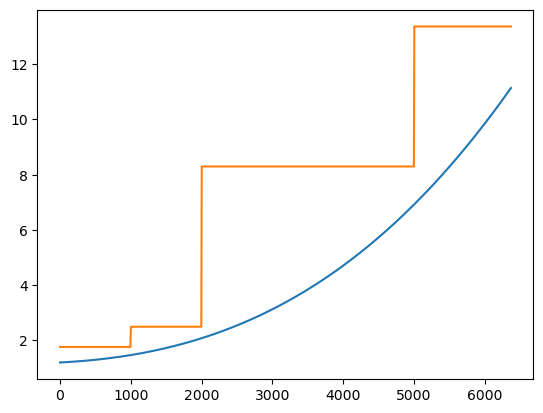

2735.5264941652786 1755.447610803199


In [11]:
intervals = np.array([0,1000, 2000, 5000, EarthDomain.bounds[0][1]])
values_vs = true_model[0].evaluate(intervals[1:])[1] * 1.2
values_vp = true_model[1].evaluate(intervals[1:])[1] * 1.2
upper_bound_function_vs = Piecewise_1D(domain=EarthDomain, 
                                        intervals=intervals,
                                        values=values_vs)
upper_bound_function_vp = Piecewise_1D(domain=EarthDomain, 
                                        intervals=intervals,
                                        values=values_vp)
plt.figure(0)
plt.plot(EarthDomain.mesh, true_model[0].evaluate(EarthDomain.mesh)[1])
plt.plot(EarthDomain.mesh, upper_bound_function_vs.evaluate(EarthDomain.mesh)[1])
plt.show()

plt.figure(1)
plt.plot(EarthDomain.mesh, true_model[1].evaluate(EarthDomain.mesh)[1])
plt.plot(EarthDomain.mesh, upper_bound_function_vp.evaluate(EarthDomain.mesh)[1])
plt.show()
norm_bound = M.norm((upper_bound_function_vs, upper_bound_function_vp))
least_norm = M.norm(least_norm_solution)
print(norm_bound, least_norm)

In [12]:
bounds = []
norm_prefactor = np.sqrt((norm_bound**2 - least_norm**2))
for index in range(no_targets):
    sqrt_H_diag = M.norm((vs_target_kernels[index] - resolving_kernels_vs[index],
                    vp_target_kernels[index] - resolving_kernels_vp[index]))
    bounds.append(norm_prefactor * sqrt_H_diag)
bounds = np.array(bounds).reshape((no_targets, 1))

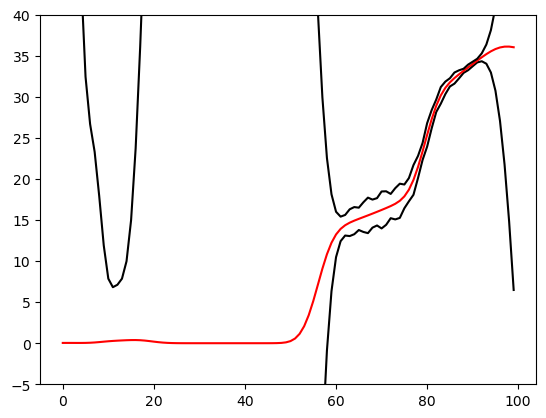

In [13]:
plt.figure(2)
plt.plot(least_norm_property - bounds, color='black')
plt.plot(least_norm_property, color='red')
plt.plot(least_norm_property + bounds, color='black')
plt.ylim(-5,40)
plt.show()